In [1]:
!python --version

Python 3.8.6


### TODO

* ~Try a built-in optimizer (like grad descent w/ momentum) instead of constant learning rate. See how convergence time changes~
* ~Plot loss~
* Plot & compare frequency responses
* Apply to audio to hear perceptual differences
* Animate changes in output signal over time, compared with target
* Run on GPU & measure performance differences
* Performance viability of realistic-length signals
* Add a simple clipping nonlinearity effect to see how `grad` does with that
* Estimate params for multiple serially-connected filters
* More than one training pair (more than just impulse response)
* Use a perceptual loss function instead of mse (steal DDSP's multi-scale spectral loss fn)
* Improve performance
  - Speed things up with [JIT](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#Using-jit-to-speed-up-functions)
  - I don't think functions truly need to be pure. I tried passing in a plain np array and changing it in place and it seemed to work fine. Maybe we can use shared buffers to improve memory usage?

In [2]:
import jax.numpy as jnp
from jax import grad, value_and_grad, jit, vmap
from jax import random
from jax.experimental import optimizers
from scipy import signal
from matplotlib import pyplot as plt
import numpy as np

In [3]:
def plot_filter(X, Y, Y_scipy, Y_estimated, title):
    column_titles = ['Target', 'Target (scipy.signal implementation)', 'Estimated']
    row_titles = ['Input', 'Output']
    Ys = [Y, Y_scipy, Y_estimated]
    _, axes = plt.subplots(2, 3, figsize=(14, 6))
    plt.suptitle(title, size=16)
    for ax, column_title in zip(axes[0], column_titles):
        ax.set_title(column_title)
    for ax, row_title in zip(axes[:,0], row_titles):
        ax.set_ylabel(row_title, size='large')
    for i, ax_column in enumerate(axes.T):
        in_plot = ax_column[0]
        in_plot.stem(X, basefmt=' ')
        in_plot.set_ylim([X.min() - 0.1, X.max() + 0.1])

        out_plot = ax_column[1]
        out_plot.stem(Ys[i], basefmt=' ')
        out_plot.set_ylim([Ys[i].min() - 0.1, Ys[i].max() + 0.1])
    plt.tight_layout()

In [4]:
def plot_loss(loss_history):
    plt.figure(figsize=(12, 3))
    plt.plot(loss_history)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss over time', size=16)

In [5]:
def plot_params(params_target, params_history, param_labels):
    params_target = params_target.T
    params_history = np.swapaxes(params_history, 0, 1)
    param_labels = param_labels.T
    _, axes = plt.subplots(*params_target.shape, figsize=(10, params_target.shape[0] * 2))
    if len(axes.shape) == 1:
        axes = np.expand_dims(axes, axis=1)
    plt.suptitle('Estimated params over time', size=16)
    for row_i in range(axes.shape[0]):
        for col_i in range(axes.shape[1]):
            plot = axes[row_i][col_i]
            plot.set_title(param_labels[row_i][col_i])
            plot.set_xlim([0, num_batches])
            plot.set_xlabel('Batch')
            plot.set_ylabel('Value')
            plot.axhline(y=params_target[row_i][col_i], c='g', linestyle='--', label='Actual params')
            plot.plot(params_history[row_i,col_i,:], c='b', label='Estimated params')
            if row_i == 0:
                plot.legend()
    plt.tight_layout()

In [6]:
def mse(X, Y):
    return ((Y - X) ** 2).mean()

In [7]:
def train(init_params, loss_fn, X, Y_target, step_size=0.1, num_batches=100):
    params_history = np.ndarray((*init_params.shape, num_batches))
    loss_history = np.zeros(num_batches)
    Y = jnp.zeros(X.size)

    opt_init, opt_update, get_params = optimizers.adam(step_size)
    opt_state = opt_init(init_params)
    for batch_i in range(num_batches):
        loss, gradient = value_and_grad(loss_fn)(get_params(opt_state), X, Y, Y_target)
        opt_state = opt_update(batch_i, gradient, opt_state)
        params_history[..., batch_i] = get_params(opt_state)
        loss_history[batch_i] = loss

    return get_params(opt_state), params_history, loss_history

In [8]:
def tick_fir_filter(x, B, inputs):
    next_inputs = jnp.concatenate([jnp.array([x]), inputs[0:-1]])
    y = B @ next_inputs
    return y, next_inputs

In [9]:
# Fills Y in-place
def fir_filter(X, Y, B):
    inputs = jnp.zeros(B.size)
    for i, x in enumerate(X):
        y, inputs = tick_fir_filter(x, B, inputs)
        Y = Y.at[i].set(y) # Y[i] = y
    return Y

In [10]:
def loss_fir(params, X, Y, Y_target):
    Y = fir_filter(X, Y, params)
    return mse(Y, Y_target)

In [11]:
X = jnp.concatenate([jnp.array([1]), jnp.zeros(13)])
Y = jnp.zeros(X.size)
B_target = jnp.array([0.1, 0.7, 0.5, 0.6])
Y_target = fir_filter(X, Y, B_target)

In [12]:
%%time
key = random.PRNGKey(42)
init_params = random.uniform(key, B_target.shape)
num_batches = 50
params, params_history, loss_history = train(init_params, loss_fir, X, Y_target, num_batches=num_batches)

CPU times: user 6.6 s, sys: 854 ms, total: 7.46 s
Wall time: 6.2 s


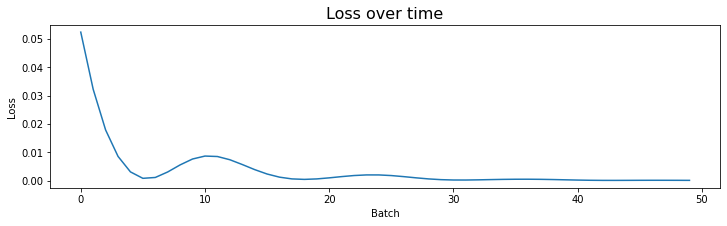

In [13]:
plot_loss(loss_history)

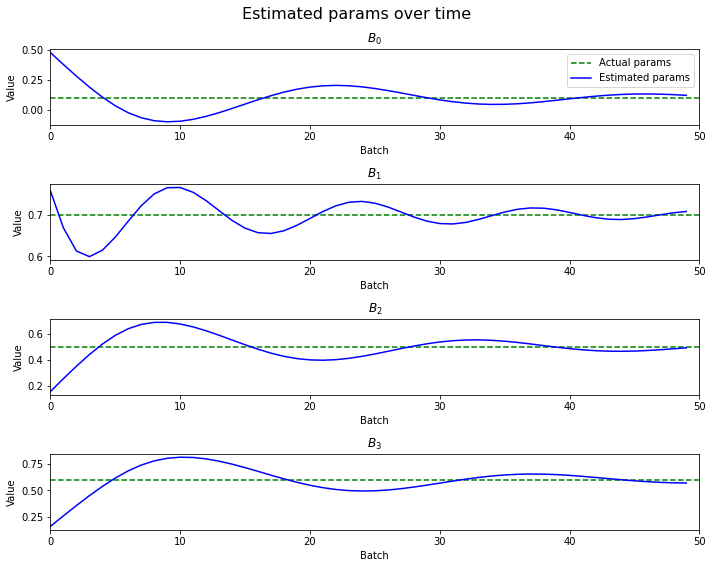

In [14]:
plot_params(np.asarray([B_target]), np.expand_dims(params_history, axis=0), np.asarray([['$B_%s$' % i for i in range(B_target.size)]]))

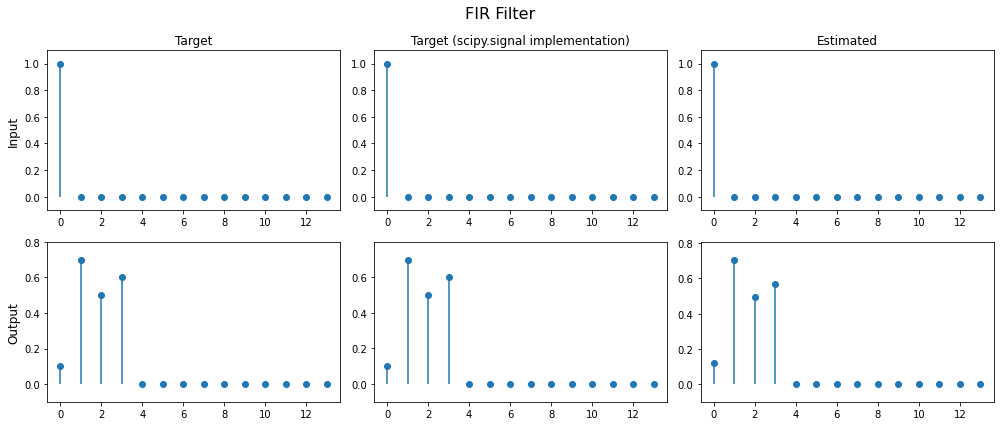

In [15]:
Y_scipy = signal.lfilter(B_target, [1.0], X)
Y_estimated = fir_filter(X, Y, params)
plot_filter(X, Y_target, Y_scipy, Y_estimated, 'FIR Filter')

In [16]:
def tick_iir_filter(x, B, A, inputs, outputs):
    next_inputs = jnp.concatenate([jnp.array([x]), inputs[0:-1]])
    y = B @ next_inputs
    if outputs.size > 0:
        y -= A[1:] @ outputs
        y /= A[0]
        next_outputs = jnp.concatenate([jnp.array([y]), outputs[0:-1]])
    else:
        next_outputs = outputs
    return y, next_inputs, next_outputs

In [17]:
# Fills Y in-place
def iir_filter(X, Y, B, A):
    inputs = jnp.zeros(B.size)
    outputs = jnp.zeros(A.size - 1)
    for i, x in enumerate(X):
        y, inputs, outputs = tick_iir_filter(x, B, A, inputs, outputs)
        Y = Y.at[i].set(y) # Y[i] = y
    return Y

In [18]:
def loss_iir(params, X, Y, Y_target):
    Y = iir_filter(X, Y, *params)
    return mse(Y, Y_target)

In [19]:
Y = jnp.zeros(X.size)
B_target, A_target = signal.butter(4, 0.5, 'low')
Y_target = iir_filter(X, Y, B_target, A_target)
key = random.PRNGKey(42)
B = random.uniform(key, (B_target.size,))
A = random.uniform(key, (A_target.size,))

In [20]:
%%time
params_target = jnp.stack([B_target, A_target])
init_params = random.uniform(key, params_target.shape)
init_params = init_params.at[1, 0].set(1.0) # help it just a bit
num_batches = 100
params, params_history, loss_history = train(init_params, loss_iir, X, Y_target, num_batches=num_batches)

CPU times: user 30.2 s, sys: 3.6 s, total: 33.8 s
Wall time: 28.5 s


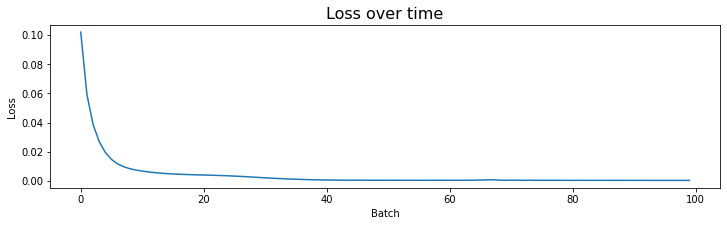

In [21]:
plot_loss(loss_history)

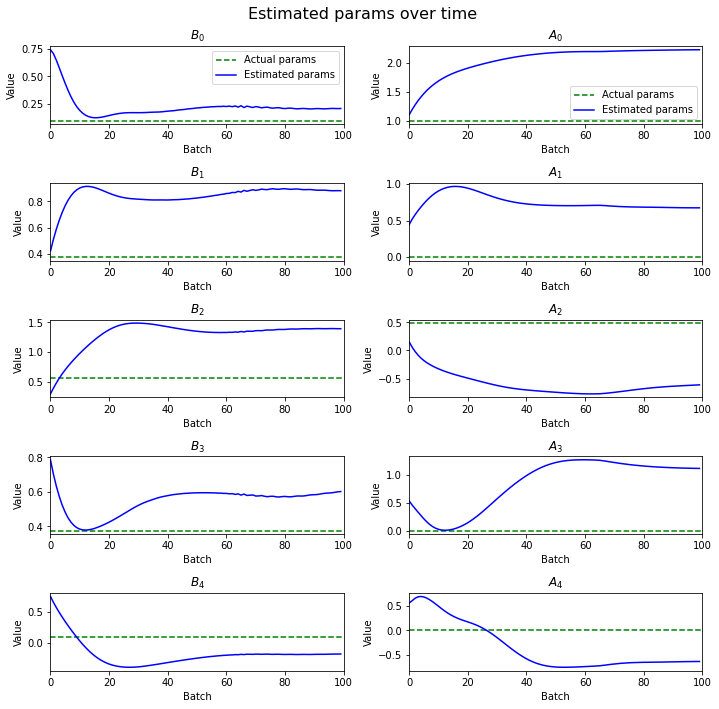

In [22]:
param_labels = np.asarray([['$B_%s$' % i for i in range(B_target.size)],
                           ['$A_%s$' % i for i in range(A_target.size)]])
plot_params(params_target, params_history, param_labels)

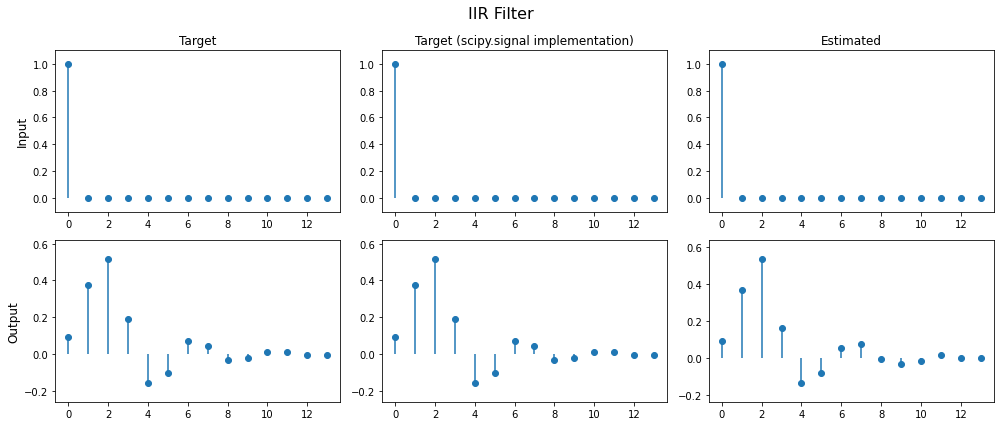

In [23]:
Y_scipy = signal.lfilter(B_target, A_target, X)
Y_estimated = iir_filter(X, Y, *params)
plot_filter(X, Y_target, Y_scipy, Y_estimated, 'IIR Filter')

In [24]:
import IPython
from scipy.io.wavfile import read as wavread

wav_fs, audio = wavread('speech-male.wav')
audio = audio.astype(float) / audio.max()
print('Original audio:')
IPython.display.Audio(audio, rate=wav_fs)

Original audio:
